In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [262]:
model_path_LSTM = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20241107/COPE/COPE_fh8_t2m_HRRR_ml_output_linear.parquet"

In [263]:
station = "COPE"
fh = 8

In [264]:
full_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20241107/COPE/11_07_2024_16:40:03_full_COPE.parquet"
)

In [265]:
lookup_path = "/home/aevans/nwp_bias/src/machine_learning/data/parent_models/HRRR/s2s/Central Lakes_t2m_HRRR_lookup_linear.csv"

lookup_path_quad = "/home/aevans/nwp_bias/src/machine_learning/data/parent_models/HRRR/s2s/Central Lakes_t2m_HRRR_lookup_quad.csv"

In [266]:
ldf = pd.read_parquet(model_path_LSTM)
# ldf = ldf.sort_index()
# ldf['Model forecast'] = ldf['Model forecast']*-1
ldf.head()

,target_error_lead_0,Model forecast,diff,valid_time
0,0.367306,-1689.047729,999.314679,2018-01-04 14:00:00
1,0.481433,-1689.047729,999.428806,2018-01-04 15:00:00
2,0.434531,-1689.047729,999.381903,2018-01-04 17:00:00
3,0.551928,-1689.047729,999.499300,2018-01-04 18:00:00
4,0.535941,-1689.047729,999.483314,2018-01-04 19:00:00


In [267]:
for i in np.arange(1, 60):
    df = ldf.copy()
    df["Model forecast"] = df["Model forecast"].shift(i).fillna(0)
    df["diff"] = df.iloc[:, 0] - df.iloc[:, 1]
    mean = st.mean(abs(df["diff"]))
    mean_s = st.mean(df["diff"] ** 2)

    print("FH", i)
    print(mean, mean_s)

FH 1
1.7374539969333602 1727.4120553246123
FH 2
1.770254200495204 1727.4122186662007
FH 3
1.8194217000585704 1727.4291324458234
FH 4
1.8778314482361653 1727.4460055044556
FH 5
1.9376583534179255 1727.4640633946838
FH 6
1.993119999108441 1727.569041974756
FH 7
2.040627177892254 1727.6295417169765
FH 8
2.0780972295645905 1727.6655717477295
FH 9
2.105392190572775 1727.6526074891508
FH 10
2.123123507400382 1727.6624584225058
FH 11
2.1324295889860574 1727.6714795171636
FH 12
2.1352353825623673 1727.6726441172796
FH 13
2.1335778109669863 1727.6708446257244
FH 14
2.128484873160485 1727.6713990067005
FH 15
2.121023579016569 1727.7183926163489
FH 16
2.1121355887468414 1727.890805823989
FH 17
2.1017359839193466 1727.8887225138167
FH 18
2.0914623695129277 1727.9531921795674
FH 19
2.081170687833273 1727.8222656144649
FH 20
2.073289128006154 1727.7943218941662
FH 21
2.067949491577859 1727.8397539679586
FH 22
2.064769080385352 1727.6624321883166
FH 23
2.0645875810764145 1727.4971553085672
FH 24
2.06

In [268]:
# ldf['Model forecast'] = ldf['Model forecast'].shift(47)

In [269]:
full_df.dropna(inplace=True)
full_df.head()

,valid_time,valid_time_cos,valid_time_sin,target_error,t2m_COPE,sh2_COPE,d2m_COPE,r2_COPE,u10_COPE,v10_COPE,...,relh_PHIL,srad_PHIL,pres_PHIL,mslp_PHIL,wspd_sonic_mean_PHIL,wspd_sonic_PHIL,wmax_sonic_PHIL,wdir_sonic_PHIL,snow_depth_PHIL,precip_total_PHIL
0,2018-01-04 17:00:00,0.997643,0.068615,-0.446671,-8.856146,0.00172,-10.683508,88.000000,0.737289,-1.851952,...,84.368820,106.645203,991.325623,992.875244,3.643813,2.931561,4.639837,357.579987,0.137972,0.14
1,2018-01-04 18:00:00,0.997643,0.068615,0.875433,-7.671362,0.00189,-9.574805,89.699997,2.485245,-4.021587,...,83.946648,133.182098,990.004822,991.537292,4.236768,5.183569,7.245194,352.842499,0.147253,0.67
2,2018-01-04 19:00:00,0.997643,0.068615,-0.610109,-9.266821,0.00170,-10.878760,91.699997,4.996105,-4.829926,...,83.799728,102.307098,988.973206,990.488647,5.117306,3.741552,6.062561,351.824005,0.144643,0.37
3,2018-01-05 15:00:00,0.996318,0.085731,-1.746891,-24.377051,0.00039,-27.948508,74.000000,10.240389,-0.769949,...,64.265663,185.213196,994.285583,996.791260,5.164124,4.857272,7.215211,277.760895,-999.000000,0.00
4,2018-01-05 16:00:00,0.996318,0.085731,-1.071793,-23.937643,0.00041,-27.368781,76.099998,9.347546,-0.418392,...,64.116371,320.816193,994.455994,996.943604,5.231020,4.919555,8.036449,270.383514,0.232297,0.00


In [270]:
for k in full_df.keys():
    print(k)

valid_time
valid_time_cos
valid_time_sin
target_error
t2m_COPE
sh2_COPE
d2m_COPE
r2_COPE
u10_COPE
v10_COPE
tp_COPE
mslma_COPE
tcc_COPE
asnow_COPE
cape_COPE
dswrf_COPE
dlwrf_COPE
gh_COPE
u_total_COPE
u_dir_COPE
lulc_cat_COPE
elev_cat_COPE
slope_cat_COPE
t2m_HARR
sh2_HARR
d2m_HARR
r2_HARR
u10_HARR
v10_HARR
tp_HARR
mslma_HARR
tcc_HARR
asnow_HARR
cape_HARR
dswrf_HARR
dlwrf_HARR
gh_HARR
u_total_HARR
u_dir_HARR
lulc_cat_HARR
elev_cat_HARR
slope_cat_HARR
t2m_GFLD
sh2_GFLD
d2m_GFLD
r2_GFLD
u10_GFLD
v10_GFLD
tp_GFLD
mslma_GFLD
tcc_GFLD
asnow_GFLD
cape_GFLD
dswrf_GFLD
dlwrf_GFLD
gh_GFLD
u_total_GFLD
u_dir_GFLD
lulc_cat_GFLD
elev_cat_GFLD
slope_cat_GFLD
t2m_PHIL
sh2_PHIL
d2m_PHIL
r2_PHIL
u10_PHIL
v10_PHIL
tp_PHIL
mslma_PHIL
tcc_PHIL
asnow_PHIL
cape_PHIL
dswrf_PHIL
dlwrf_PHIL
gh_PHIL
u_total_PHIL
u_dir_PHIL
lulc_cat_PHIL
elev_cat_PHIL
slope_cat_PHIL
lat_COPE
lon_COPE
elev_COPE
tair_COPE
ta9m_COPE
td_COPE
relh_COPE
srad_COPE
pres_COPE
mslp_COPE
wspd_sonic_mean_COPE
wspd_sonic_COPE
wmax_sonic_COPE
w

In [271]:
# ldf["valid_time"] = full_df["valid_time"]

In [272]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            f = int(len(df_test) * 0.5)
            df_val = df_test.iloc[:f]
            df_test = df_test[-f:]

    return df_train["valid_time"], df_test["valid_time"], df_val["valid_time"]

In [273]:
ldf["valid_time"] = pd.to_datetime(ldf["valid_time"])

In [274]:
df_train, df_test, df_val = which_fold(ldf, 4)

In [275]:
test_set_start = df_test.iloc[0]
test_set_start

Timestamp('2023-06-16 10:00:00')

In [276]:
test_set_finish = df_test.iloc[-1]
test_set_finish

Timestamp('2023-12-31 23:00:00')

In [277]:
df_val.iloc[0]

Timestamp('2022-11-29 21:00:00')

In [278]:
df_val.iloc[-1]

Timestamp('2023-06-16 09:00:00')

In [279]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

## Time filter 

In [280]:
time1 = datetime(2023, 1, 1, 0, 0, 0)
time2 = datetime(2023, 12, 30, 23, 0, 0)

ldf = date_filter(ldf, time1, time2)
full_df = date_filter(full_df, time1, time2)

In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def create_heatmap(df, x_column="target_error_lead_0", y_column="Model forecast"):
    # Round values
    df[x_column] = np.round(df[x_column] / 1.0) * 1.0
    df[y_column] = np.round(df[y_column] / 1.0) * 1.0

    # Pivot the DataFrame to create a matrix suitable for the heatmap
    heatmap_data = pd.pivot_table(
        df, index=y_column, columns=x_column, aggfunc="size", fill_value=0
    )

    # Calculate percentages
    total = heatmap_data.sum()
    heatmap_data_percent = (heatmap_data / total) * 100

    # Create the heatmap using seaborn
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        heatmap_data_percent,
        vmax=100,
        cmap="Reds",
        annot=True,
        fmt=".1f",  # Format as percentage with one decimal place
        cbar_kws={"label": "Percentage (%)"},  # Add color bar label
    )

    # Set the labels and title
    plt.xlabel("Target")
    plt.ylabel("LSTM")
    plt.title("Heatmap of Target vs LSTM")

    # Show the heatmap
    plt.show()

In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


def create_scatterplot(df, x_column="target_error_lead_0", y_column="Model forecast"):
    # Calculate point density
    xy = np.vstack([df[x_column], df[y_column]])
    z = gaussian_kde(xy)(xy)

    plt.figure(figsize=(8, 8))

    # Create the scatterplot
    scatter = plt.scatter(
        df[x_column],
        df[y_column],
        c=z,
        cmap="YlOrRd",
        s=100,
        edgecolor="black",
        alpha=0.3,
    )

    # Add color bar with label
    cbar = plt.colorbar(scatter)
    cbar.set_label("Point Density")

    # Set labels and title
    plt.xlabel("Target", fontsize=18)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.ylabel("LSTM", fontsize=18)
    plt.title("Scatterplot with Density and Colorbar", fontsize=24)

    # Show the plot
    plt.show()

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def create_scatterplot_heatmap(
    df, x_column="target_error_lead_0", y_column="Model forecast", gridsize=100
):
    plt.figure(figsize=(16, 12))

    # Create a 2D histogram (binning) to calculate point concentration
    hb = plt.hexbin(
        df[x_column], df[y_column], gridsize=gridsize, cmap="viridis", mincnt=1
    )

    # Add color bar with label
    cbar = plt.colorbar(hb)
    cbar.set_label("Number of Points")

    # Set labels and title
    plt.xlabel("Target", fontsize=18)
    plt.ylabel("LSTM", fontsize=18)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.title("Scatterplot Heatmap with Point Frequency", fontsize=24)

    # Show the plot
    plt.show()

In [284]:
import matplotlib.pyplot as plt
import numpy as np


def create_hexbin_heatmap(
    df, x_column="target_error_lead_0", y_column="Model forecast"
):
    plt.figure(figsize=(16, 12))

    # Create hexbin plot with continuous color density
    hexplot = plt.hexbin(
        df[x_column], df[y_column], gridsize=50, cmap="cividis", mincnt=1
    )

    # Add color bar with label
    cbar = plt.colorbar(hexplot)
    cbar.set_label("Count in Bin")

    # Set labels and title
    plt.xlabel("Target", fontsize=18)
    plt.ylabel("LSTM", fontsize=18)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title("Hexbin Scatterplot Heatmap with Colorbar", fontsize=24)
    # Add gridlines
    plt.grid(visible=True, which="both", color="gray", linestyle="--", linewidth=0.5)

    # Show the plot
    plt.show()

In [285]:
def quantile_regression(x, y):
    X = x[:, np.newaxis]
    quantiles = [0.10, 0.5, 0.90]
    predictions = {}
    out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

    predictions_df = pd.DataFrame()
    predictions_df["target"] = x

    for q in quantiles:
        predictions_df[q] = predictions.get(q)

    return qr, y_pred, predictions_df

In [286]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def ml_output(df, full_df, fold, station, test_set_start, test_set_finish, fh):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df["target_error_lead_0"]),
        c="black",
        linewidth=1,
        label="Target",
    )

    plt.plot(
        np.array(x),
        np.array(df["Model forecast"]),
        c="red",
        linewidth=3,
        alpha=0.7,
        label="LSTM Output",
    )

    # plt.axvline(
    #     x=test_set_start,
    #     c="green",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Start",
    # )
    # plt.axvline(
    #     x=test_set_finish,
    #     c="red",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Finish",
    # )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, -4, 4.1, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, -4, 4.1, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(
        f"Precipitation Error LSTM Output v Target: {station}: FH{fh}", fontsize=28
    )
    # plt.ylim(-5, 5.)
    ax.legend()

    plt.show()

In [287]:
def find_linear_coefficients(df):
    """
    Adjusts the 'Model forecast' column of the input DataFrame by aligning it with
    the statistics of the 'target_error_lead_0' column. The alignment involves
    subtracting the difference in means and scaling based on the maximum absolute values
    of both columns. The result is that the 'Model forecast' is transformed to better fit
    the target error profile.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with 'target_error_lead_0' and 'Model forecast' columns.

    Returns:
    pandas.DataFrame: The modified DataFrame with updated 'Model forecast' values.
    """

    # Calculate the mean of 'target_error_lead_0' and 'Model forecast'
    mean1 = st.mean(df["target_error_lead_0"])
    mean2 = st.mean(df["Model forecast"])

    # Find the row with the maximum absolute value in 'target_error_lead_0'
    max1_index = df["target_error_lead_0"].abs().idxmax()
    # Retrieve the row that contains this maximum absolute value
    max_row = df.loc[max1_index]

    # Find the row with the maximum absolute value in 'target_error_lead_0'
    min1_index = df["target_error_lead_0"].abs().idxmin()
    # Retrieve the row that contains this maximum absolute value
    min_row = df.loc[min1_index]

    # Find the maximum absolute value of 'target_error_lead_0' and 'Model forecast'
    max1 = abs(max_row["target_error_lead_0"])
    max2 = abs(max_row["Model forecast"])

    # Find the maximum absolute value of 'target_error_lead_0' and 'Model forecast'
    min1 = abs(min_row["target_error_lead_0"])
    min2 = abs(min_row["Model forecast"])

    # Calculate the difference in means between 'Model forecast' and 'target_error_lead_0'
    diff = mean2 - mean1

    # # Recalculate the maximum absolute value after adjustment
    # max1 = abs(max(df['target_error_lead_0']))
    # max2 = abs(max(df['Model forecast']))

    # Scale the 'Model forecast' by the ratio of maximum absolute values
    multiply1 = max1 / max2

    multiply2 = min1 / min2

    multiply = (multiply1 + multiply2) / 2.0

    # Return the modified DataFrame
    return diff, multiply

In [288]:
def refit_output(df, diff, multiply):
    # Adjust the 'Model forecast' by subtracting the difference in means
    df["Model forecast"] = df["Model forecast"] - diff
    df["Model forecast"] = df["Model forecast"] * multiply

    # Calculate the median of 'target_error_lead_0' and 'Model forecast'
    mean3 = st.median(df["target_error_lead_0"])
    mean4 = st.median(df["Model forecast"])

    # Center both 'target_error_lead_0' and 'Model forecast' by subtracting their medians
    df["target_error_lead_0"] = df["target_error_lead_0"] - mean3
    df["Model forecast"] = df["Model forecast"] - mean4

    return df

In [289]:
def refit_output_quad(df, a, b, c):
    quadratic_fit = np.poly1d([a, b, c])
    # adjust total model output
    adjusted_lstm_output = df_out["Model forecast"] + quadratic_fit(
        df_out["Model forecast"]
    )
    df_out["Model forecast"] = adjusted_lstm_output

    # Calculate the median of 'target_error_lead_0' and 'Model forecast'
    mean3 = st.median(df["target_error_lead_0"])
    mean4 = st.median(df["Model forecast"])

    # Center both 'target_error_lead_0' and 'Model forecast' by subtracting their medians
    df["target_error_lead_0"] = df["target_error_lead_0"] - mean3
    df["Model forecast"] = df["Model forecast"] - mean4

    return df

In [290]:
def get_alpha_diff_from_lookup(ldf, lookup_path, station, fh):
    lookup = pd.read_csv(lookup_path)
    lookup = lookup[lookup["station"] == station]
    lookup = lookup[lookup["forecast_hour"] == fh]

    alpha = lookup["alpha"].values
    diff = lookup["diff"].values

    return alpha, diff

In [291]:
def get_alpha_beta_charli_from_lookup(ldf, lookup_path, station, fh):
    lookup = pd.read_csv(lookup_path)
    lookup = lookup[lookup["station"] == station]
    lookup = lookup[lookup["forecast_hour"] == fh]

    alpha = lookup["alpha"].values
    beta = lookup["beta"].values
    charli = lookup["charli"].values

    return alpha, beta, charli

In [292]:
# alpha, diff = get_alpha_diff_from_lookup(ldf, lookup_path, station, fh)

In [293]:
# a, b, c = get_alpha_beta_charli_from_lookup(ldf, lookup_path_quad, station, fh)

In [294]:
# ldf_linear = refit_output(ldf, alpha, diff)

In [295]:
# ldf_quad = refit_output_quad(ldf, a, b, c)

In [296]:
# ldf_linear["diff"] = ldf_linear.iloc[:, 0] - ldf_linear.iloc[:, 1]
# ldf_quad["diff"] = ldf_quad.iloc[:, 0] - ldf_quad.iloc[:, 1]

In [297]:
ldf["diff"] = ldf.iloc[:, 0] - ldf.iloc[:, 1]

In [298]:
mean = st.mean(abs(ldf["diff"]))
mean

0.7980944045835826

In [299]:
mean_s = st.mean(ldf["diff"] ** 2)
mean_s

1.0930858117251716

In [300]:
# ldf['Model forecast'] = ldf['Model forecast']*10

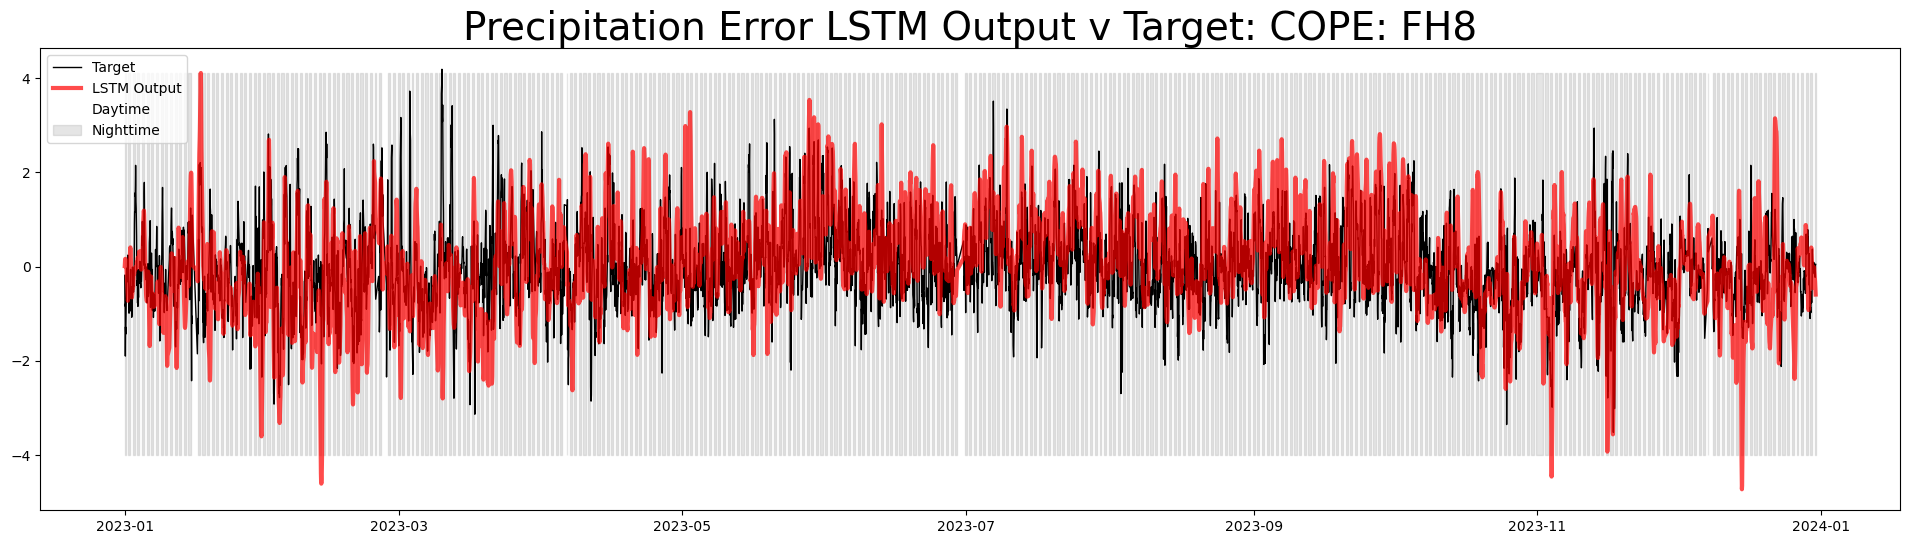

In [301]:
x = ml_output(ldf, full_df, 4, station, test_set_start, test_set_finish, fh)

In [302]:
# mean = st.mean(abs(ldf_quad["diff"]))
# mean

In [303]:
# mean_s = st.mean(ldf_quad["diff"] ** 2)
# mean_s

In [304]:
# x = ml_output(ldf_quad, full_df, 4, station, test_set_start, test_set_finish, fh)

In [305]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [306]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [307]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

In [308]:
full_df.head()

,valid_time,valid_time_cos,valid_time_sin,t2m_COPE,sh2_COPE,d2m_COPE,r2_COPE,u10_COPE,v10_COPE,tp_COPE,...,relh_COPE,srad_COPE,pres_COPE,mslp_COPE,wspd_sonic_mean_COPE,wspd_sonic_COPE,wmax_sonic_COPE,wdir_sonic_COPE,snow_depth_COPE,precip_total_COPE
37765,2023-01-01 01:00:00,0.999853,0.017166,4.505945,0.00528,4.237390,83.400002,-1.272812,3.045025,0.34,...,98.820099,0.141899,976.345886,977.523438,0.473852,0.483317,0.813856,283.171204,0.052915,0.000000
37766,2023-01-01 02:00:00,0.999853,0.017166,3.859583,0.00513,3.838892,83.300003,-0.713910,3.008915,0.71,...,99.553848,0.080625,975.973999,977.080200,0.416352,0.439608,1.263524,43.005322,-999.000000,0.309998
37767,2023-01-01 03:00:00,0.999853,0.017166,3.950708,0.00519,3.927026,83.199997,2.387512,2.033503,1.24,...,99.828651,0.103198,975.944397,976.931152,3.035805,1.689880,2.571532,265.147003,0.051030,0.250000
37768,2023-01-01 04:00:00,0.999853,0.017166,3.747888,0.00518,3.775476,86.300003,3.508103,1.999485,2.25,...,98.623466,0.161240,975.753601,976.530823,3.456612,4.118382,5.933698,263.056793,0.046431,0.289978
37769,2023-01-01 05:00:00,0.999853,0.017166,3.963831,0.00509,3.739893,83.900002,3.774835,2.233225,2.88,...,98.883430,0.154787,976.400391,977.301453,2.775783,2.821182,4.268343,264.012207,0.041130,0.220001


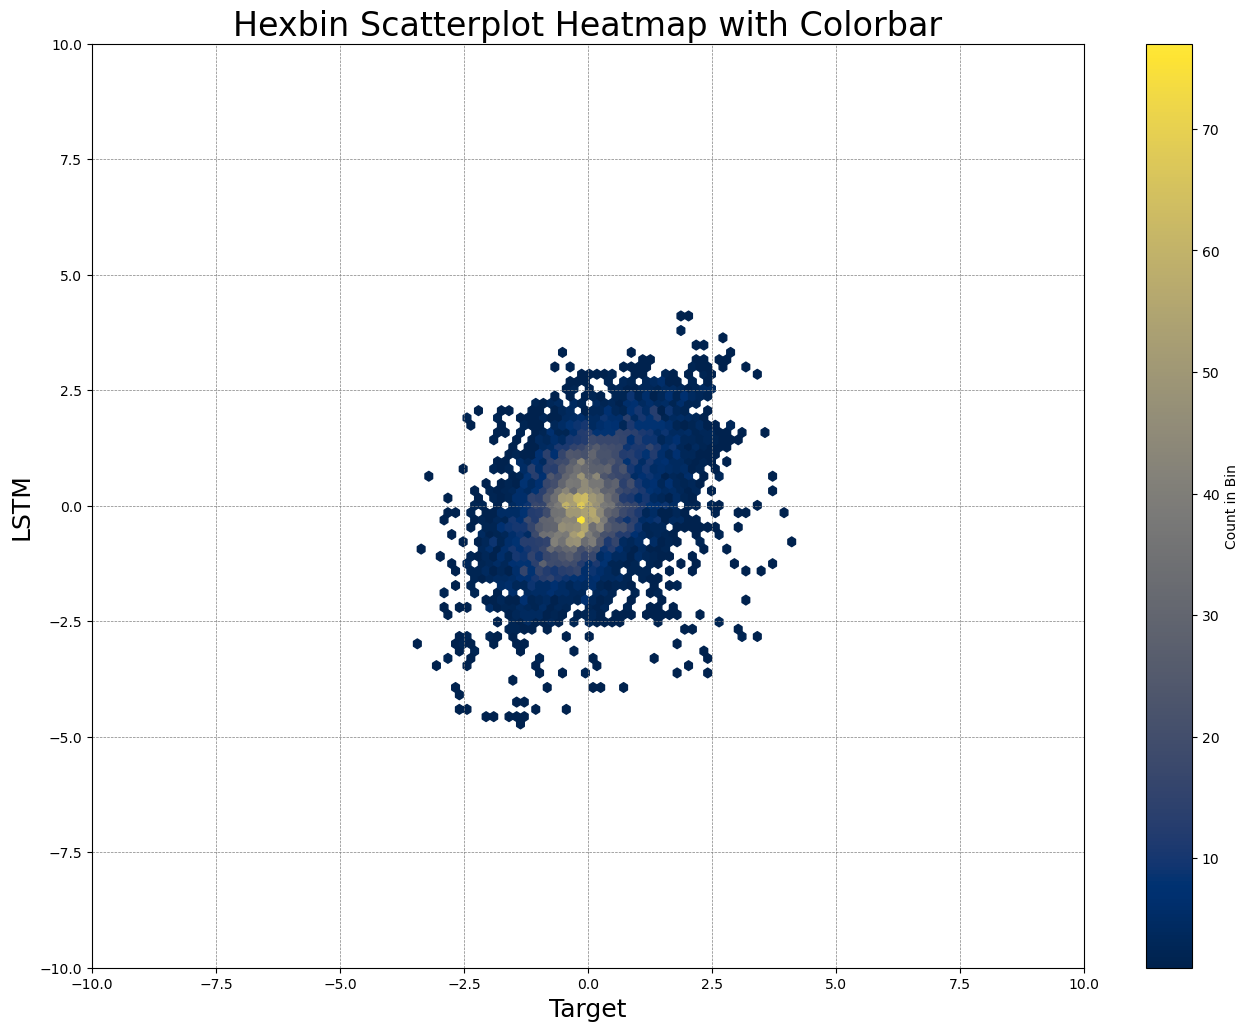

In [309]:
create_hexbin_heatmap(ldf)

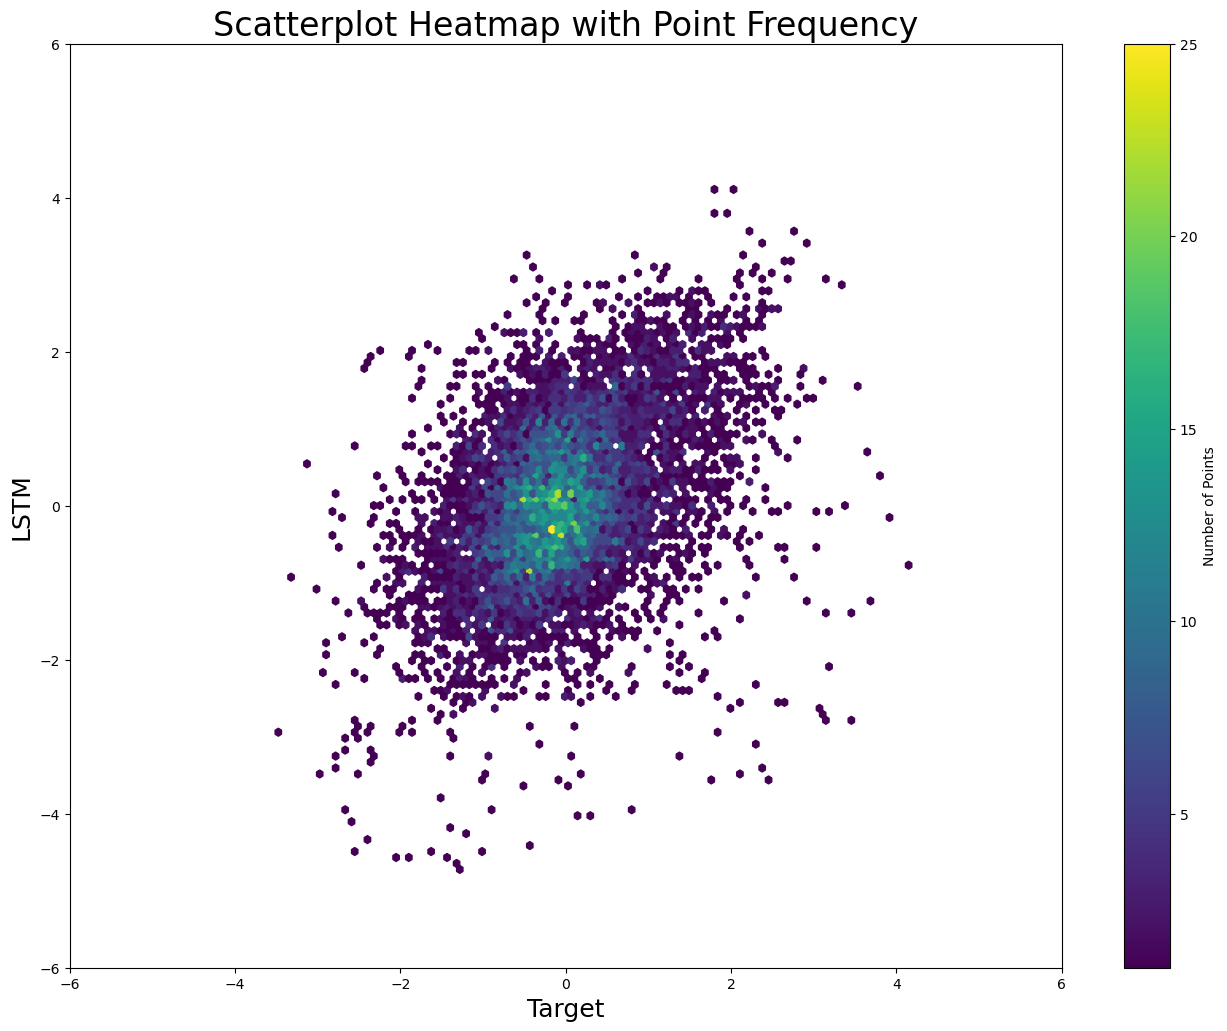

In [310]:
create_scatterplot_heatmap(ldf)

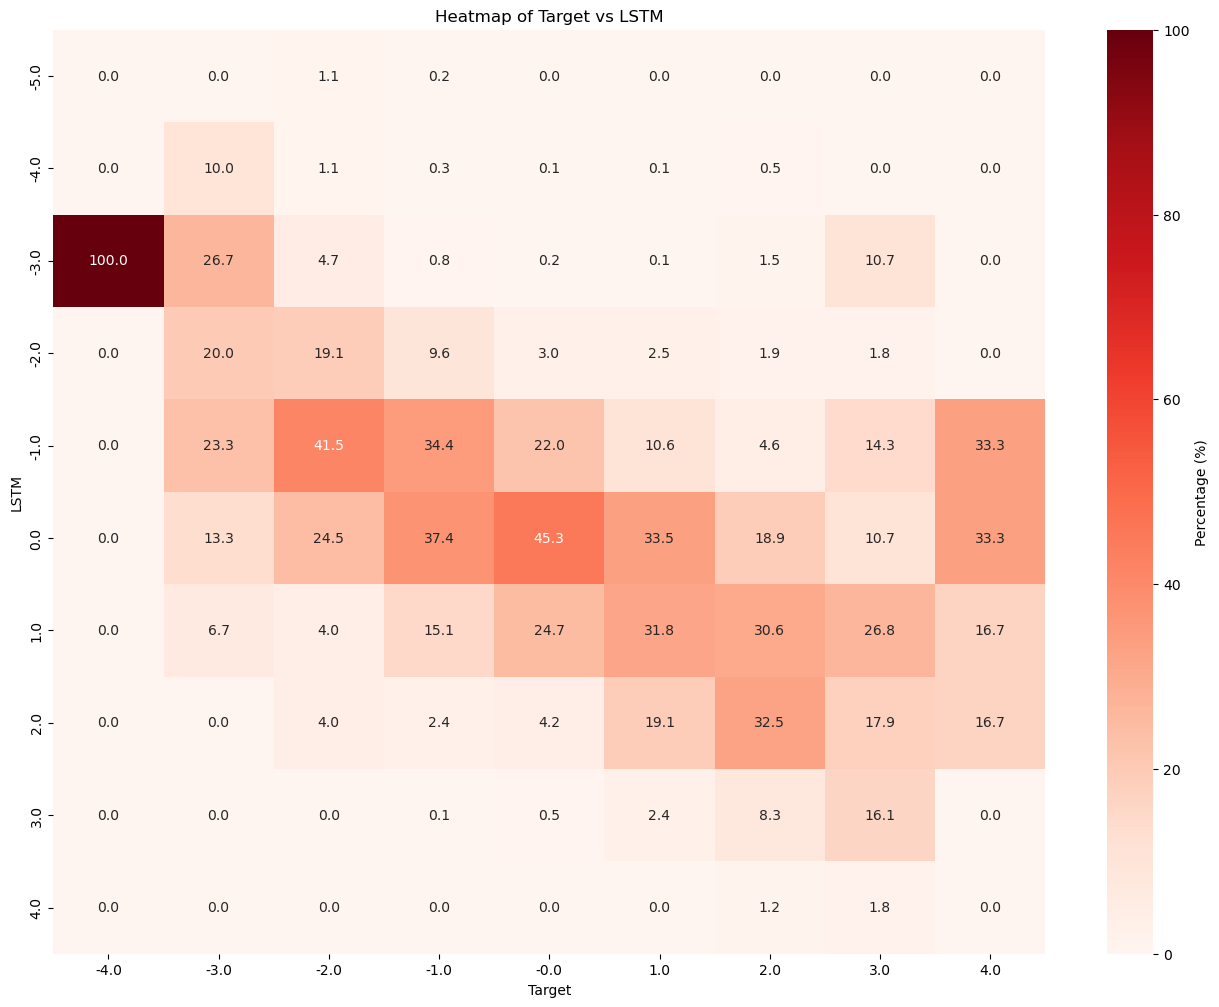

In [311]:
create_heatmap(ldf)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/2351311710.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])


[0.2142952864445796,
 0.4115658530847681,
 0.42976378278045174,
 -0.10573277319208894,
 -0.24515595315650107,
 -0.3784079570418631,
 -0.45571972664470556,
 -0.3684304847946347,
 -0.43475387768072404,
 -0.1258510992803924,
 -0.0162203601403737,
 0.12764587201736116]

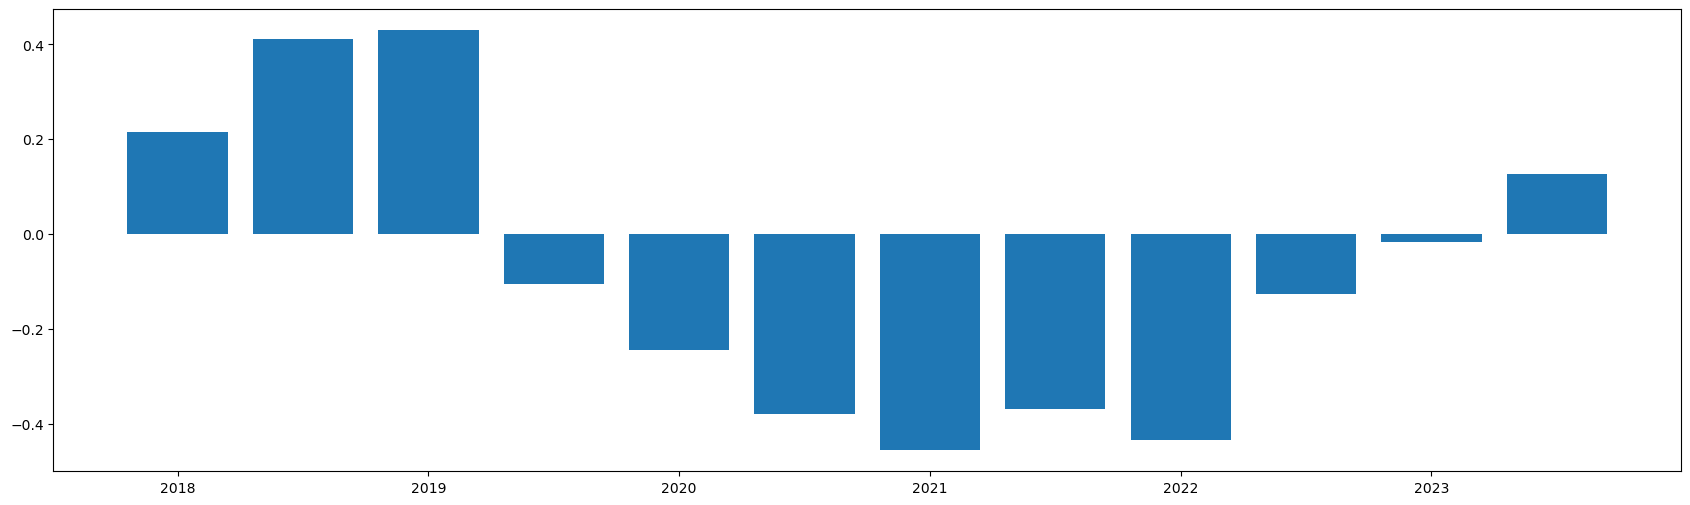

In [312]:
err_by_month = groupby_month(ldf, "diff")
err_by_month

In [313]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

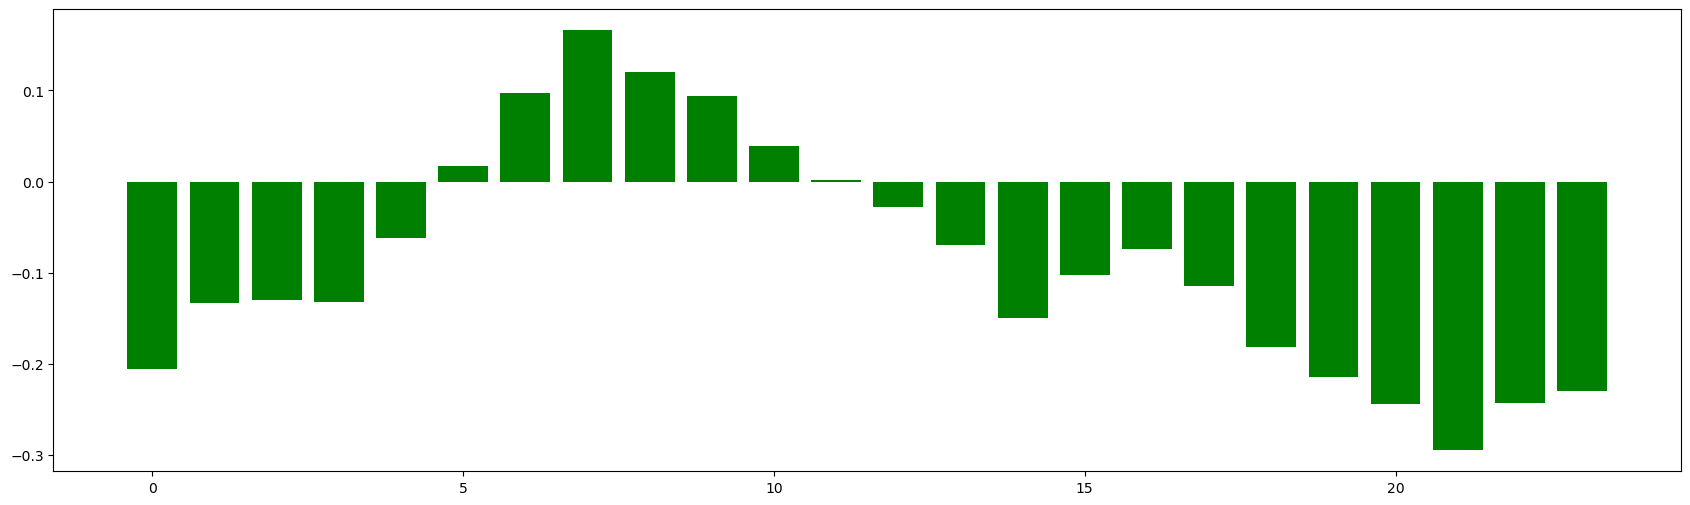

In [314]:
err_by_time = groupby_time(ldf, "diff")

In [315]:
import calendar


def groupby_month_total(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))

    # Get a colormap
    cmap = plt.get_cmap("RdBu")
    # Normalize your data to map to the colormap
    norm = plt.Normalize(min(the_list), max(the_list))
    colors = cmap(norm(the_list))

    # Create a bar chart
    plt.bar(x, the_list, color=colors)
    ax.set_xticks(x)  # Set x-ticks to be at the positions of the months
    month_labels = [calendar.month_name[month] for month in GB.index]
    ax.set_xticklabels(month_labels)  # Label x-ticks with month numbers

    plt.show()
    return the_list

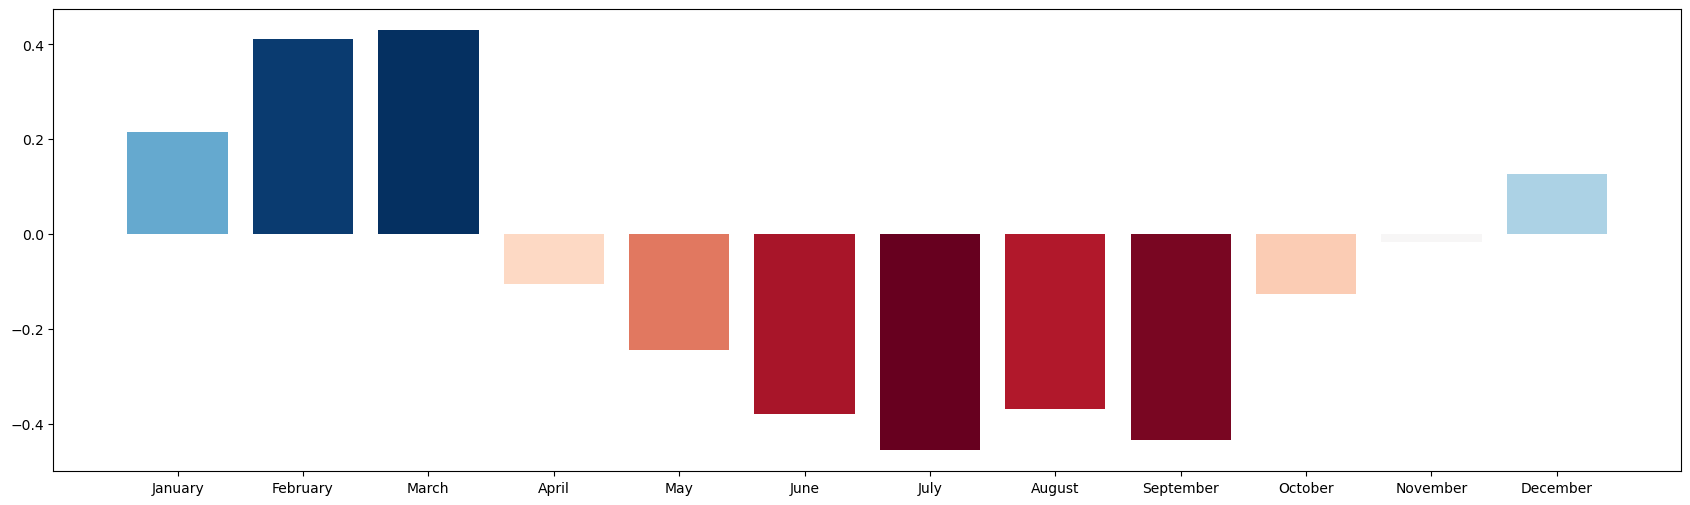

[0.2142952864445796,
 0.4115658530847681,
 0.42976378278045174,
 -0.10573277319208894,
 -0.24515595315650107,
 -0.3784079570418631,
 -0.45571972664470556,
 -0.3684304847946347,
 -0.43475387768072404,
 -0.1258510992803924,
 -0.0162203601403737,
 0.12764587201736116]

In [316]:
groupby_month_total(ldf, "diff")

In [317]:
def myround(x, base):
    return base * round(x / base)

In [318]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [319]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [320]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(
        figsize=(21, 6), facecolor="slategrey", constrained_layout=True
    )
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [321]:
# for k in full_df.keys():
#     print(k)

In [322]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [323]:
# Reset index for both DataFrames to ensure alignment
full_df = full_df.reset_index(drop=True)
ldf = ldf.reset_index(drop=True)
full_df["Abs_err"] = ldf["diff"]

In [324]:
full_df.dropna(inplace=True)

In [325]:
temp_df, instances = err_bucket(full_df, f"tair_{station}", 2)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

In [326]:
instances

-36      1.0
-34      4.0
-32      1.0
-30      2.0
-28      3.0
-26      5.0
-24     11.0
-22      8.0
-20      6.0
-18     11.0
-16     24.0
-14     38.0
-12     59.0
-10     78.0
-8     156.0
-6     222.0
-4     311.0
-2     547.0
 0     647.0
 2     703.0
 4     584.0
 6     470.0
 8     510.0
 10    482.0
 12    433.0
 14    466.0
 16    562.0
 18    570.0
 20    571.0
 22    393.0
 24    282.0
 26    177.0
 28    104.0
 30     22.0
 32      3.0
Name: (34,), dtype: float64

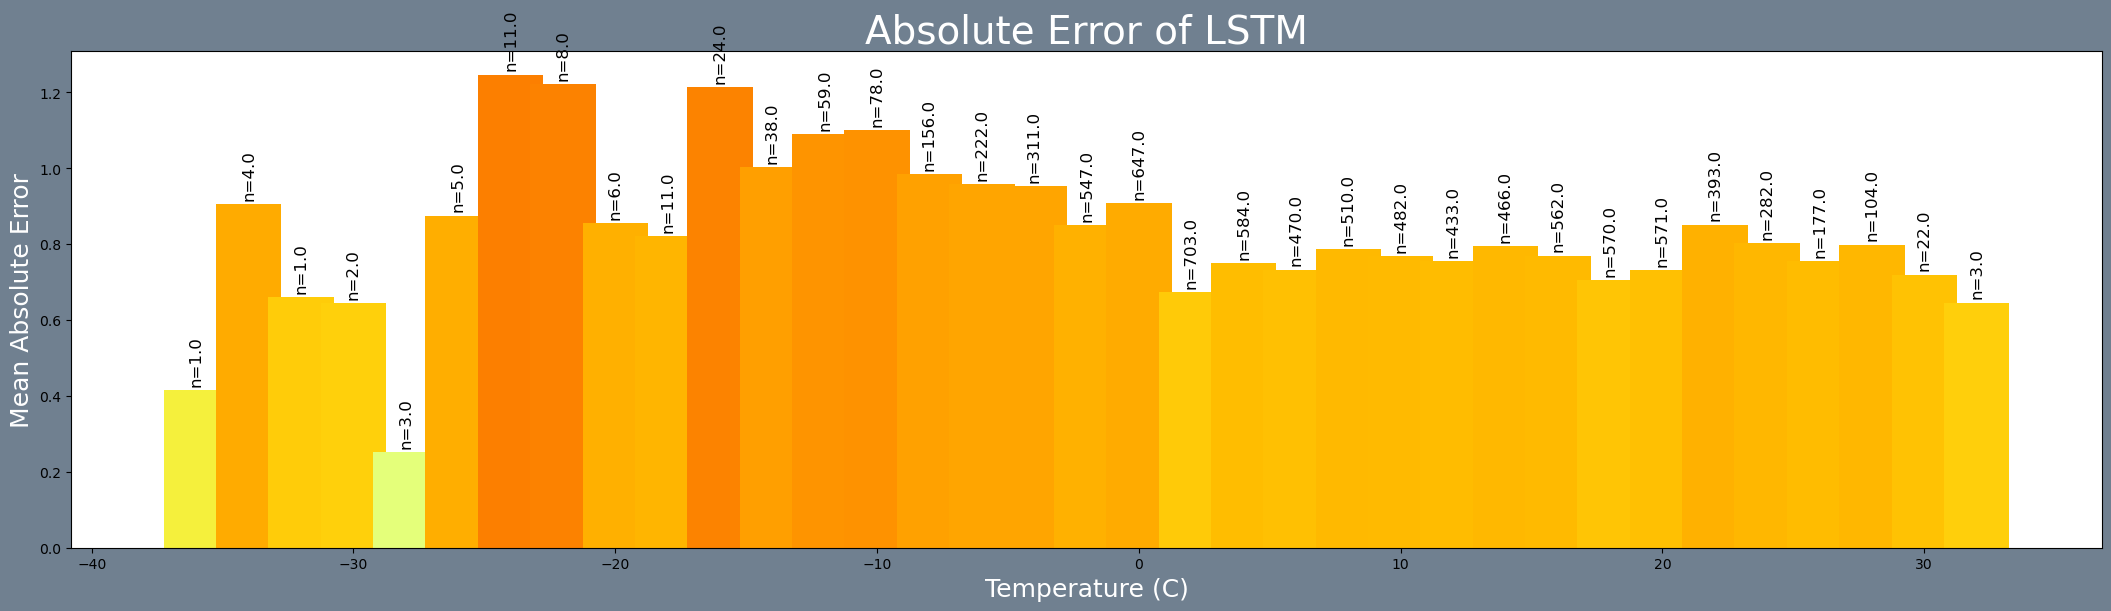

In [327]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [328]:
relh_df, instances = err_bucket(full_df, f"relh_{station}", 2)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

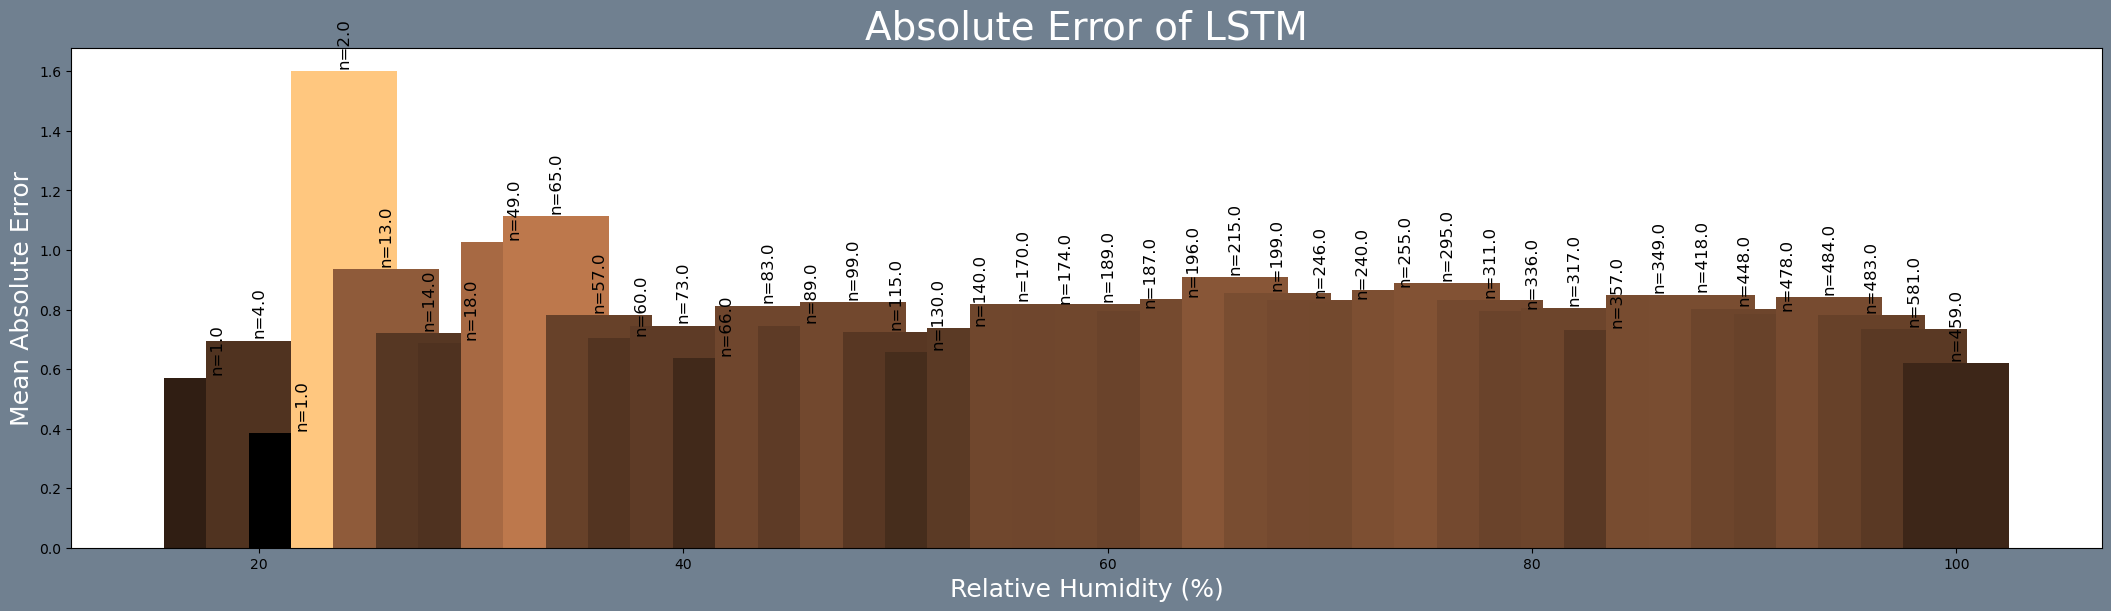

In [329]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 5.0)

In [330]:
new_df, instances = err_bucket(full_df, f"srad_{station}", 40)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

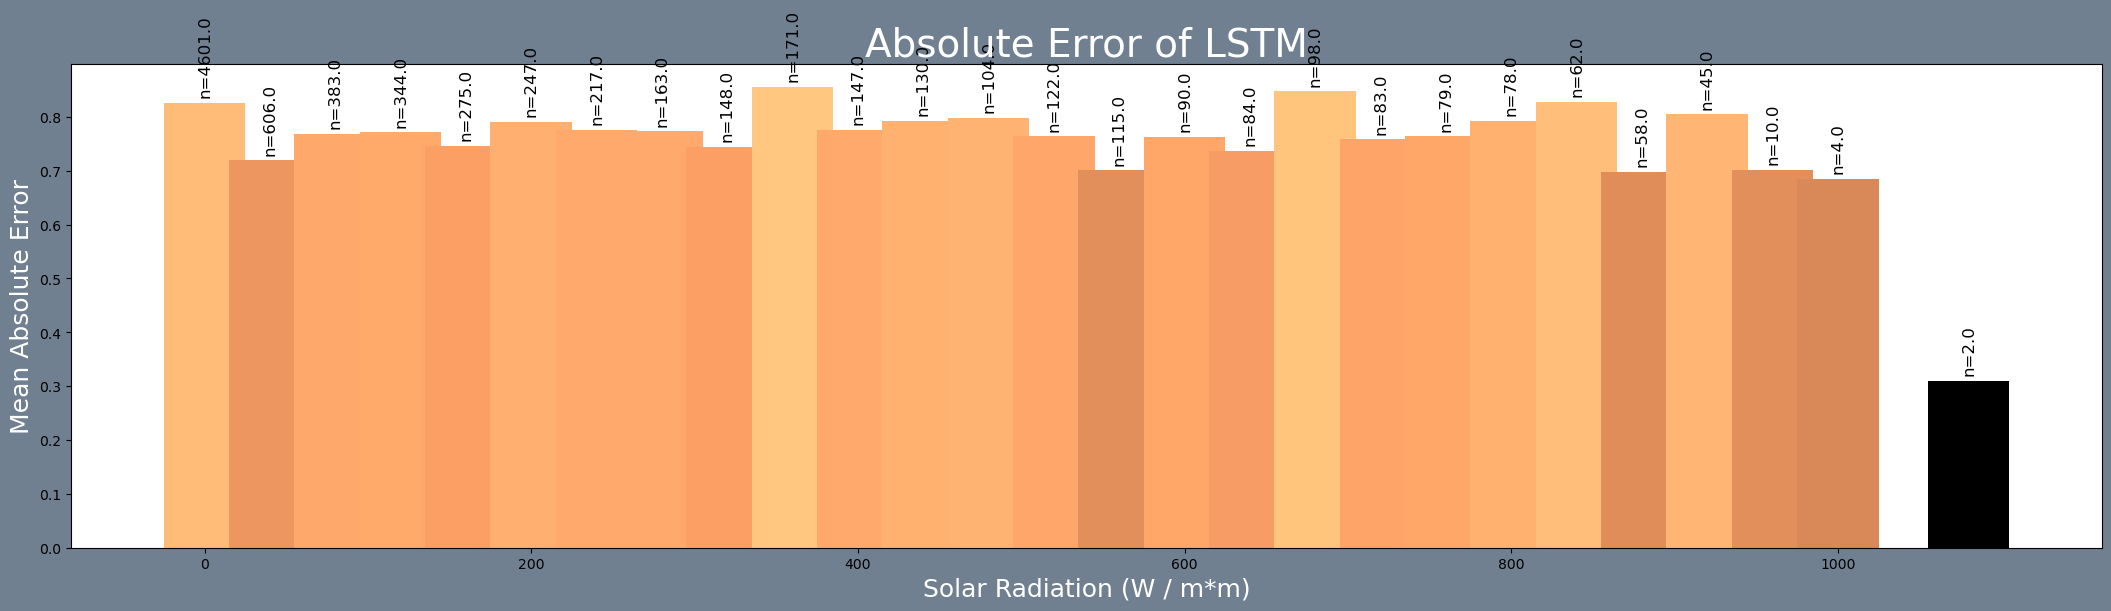

In [331]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [332]:
pres_df, instances = err_bucket(full_df, f"pres_{station}", 2)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

In [333]:
print(f'The mean pressure at {station} is {full_df[f"pres_{station}"].mean()}')

The mean pressure at COPE is 985.5704956054688


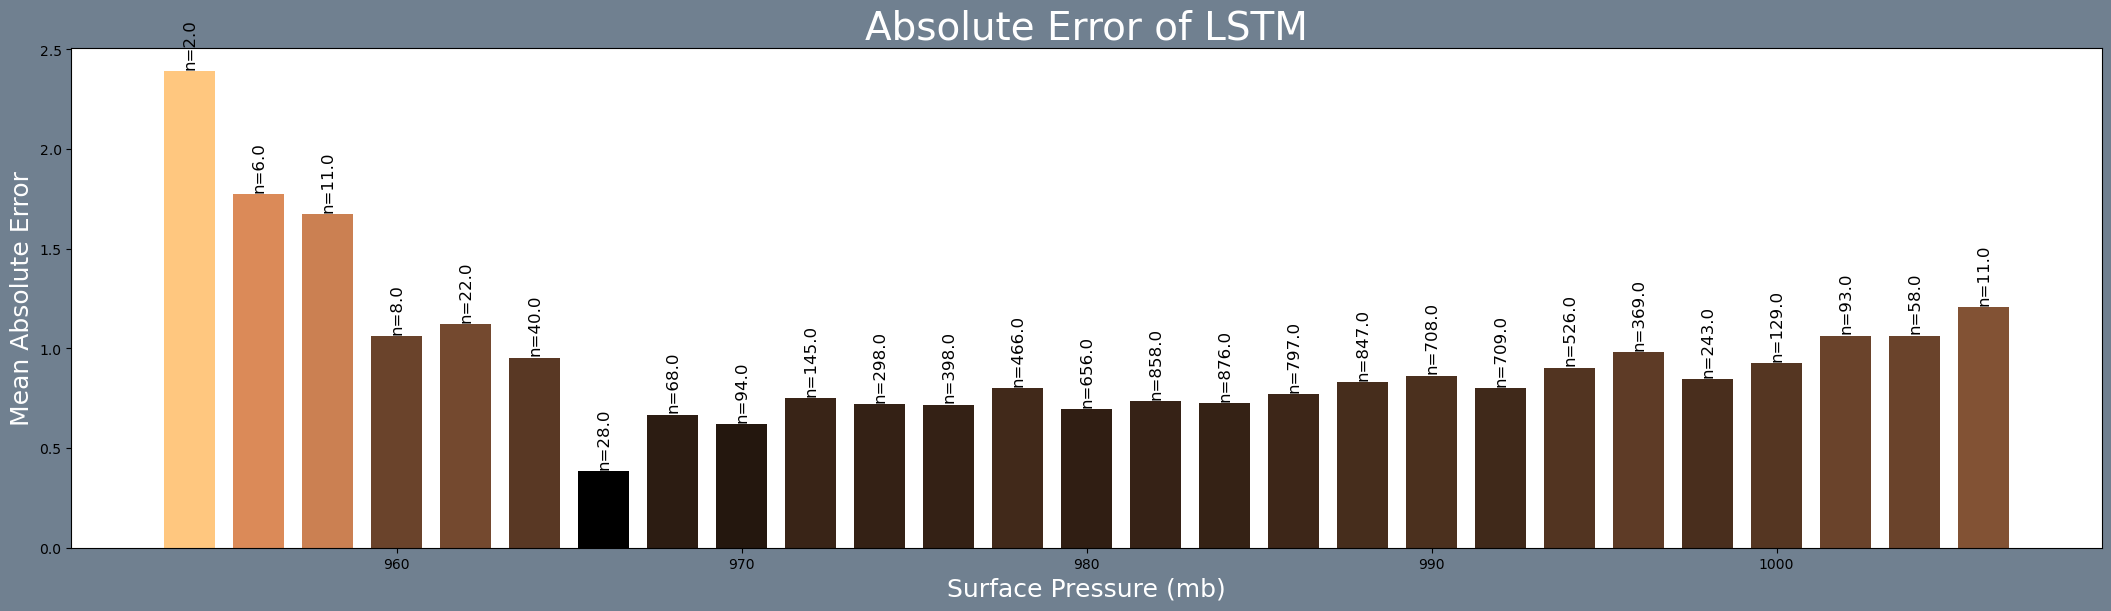

In [334]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [335]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [336]:
rain_df, instances = err_bucket(full_df, f"precip_total_{station}", 0.1)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

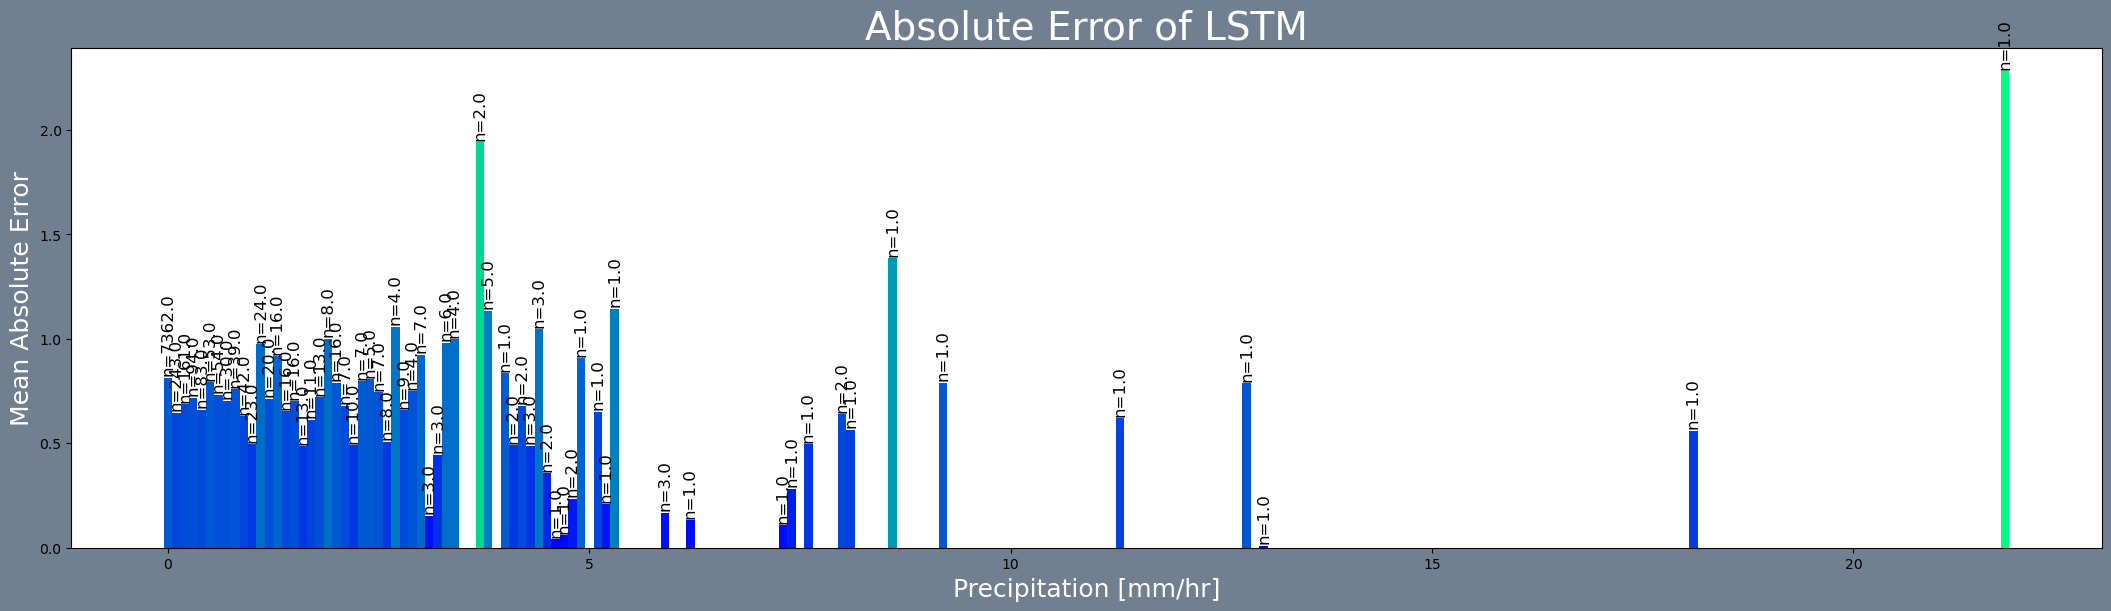

In [337]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 0.1)

In [338]:
snow_df, instances = round_small(full_df, f"snow_depth_{station}", 2)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1323447786.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1323447786.py:26: FutureWarning: Ch

In [339]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

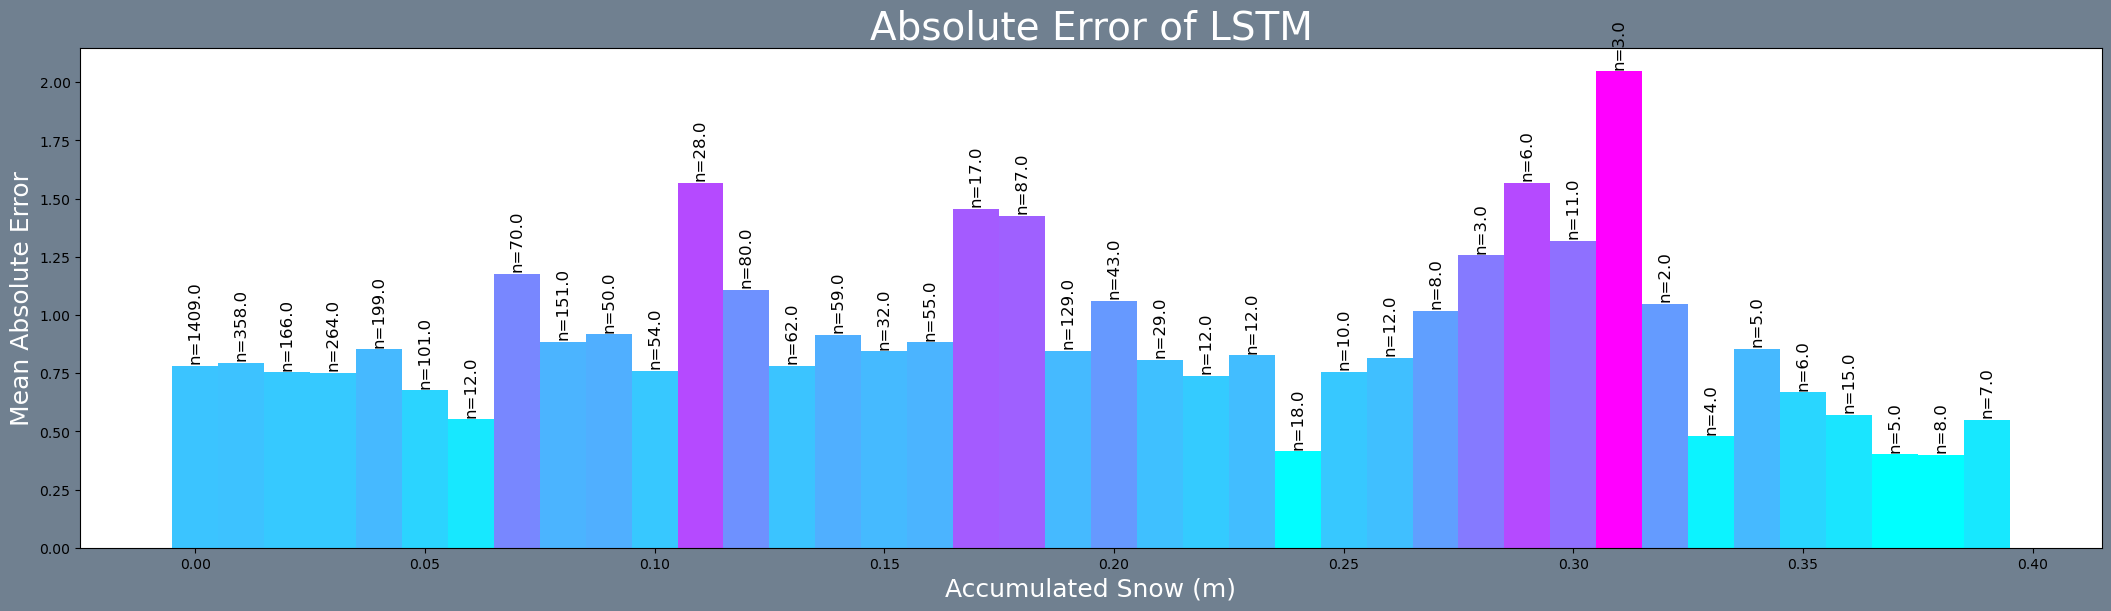

In [340]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [341]:
wmax, instances = err_bucket(full_df, f"wmax_sonic_{station}", 2)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

Hello camera man


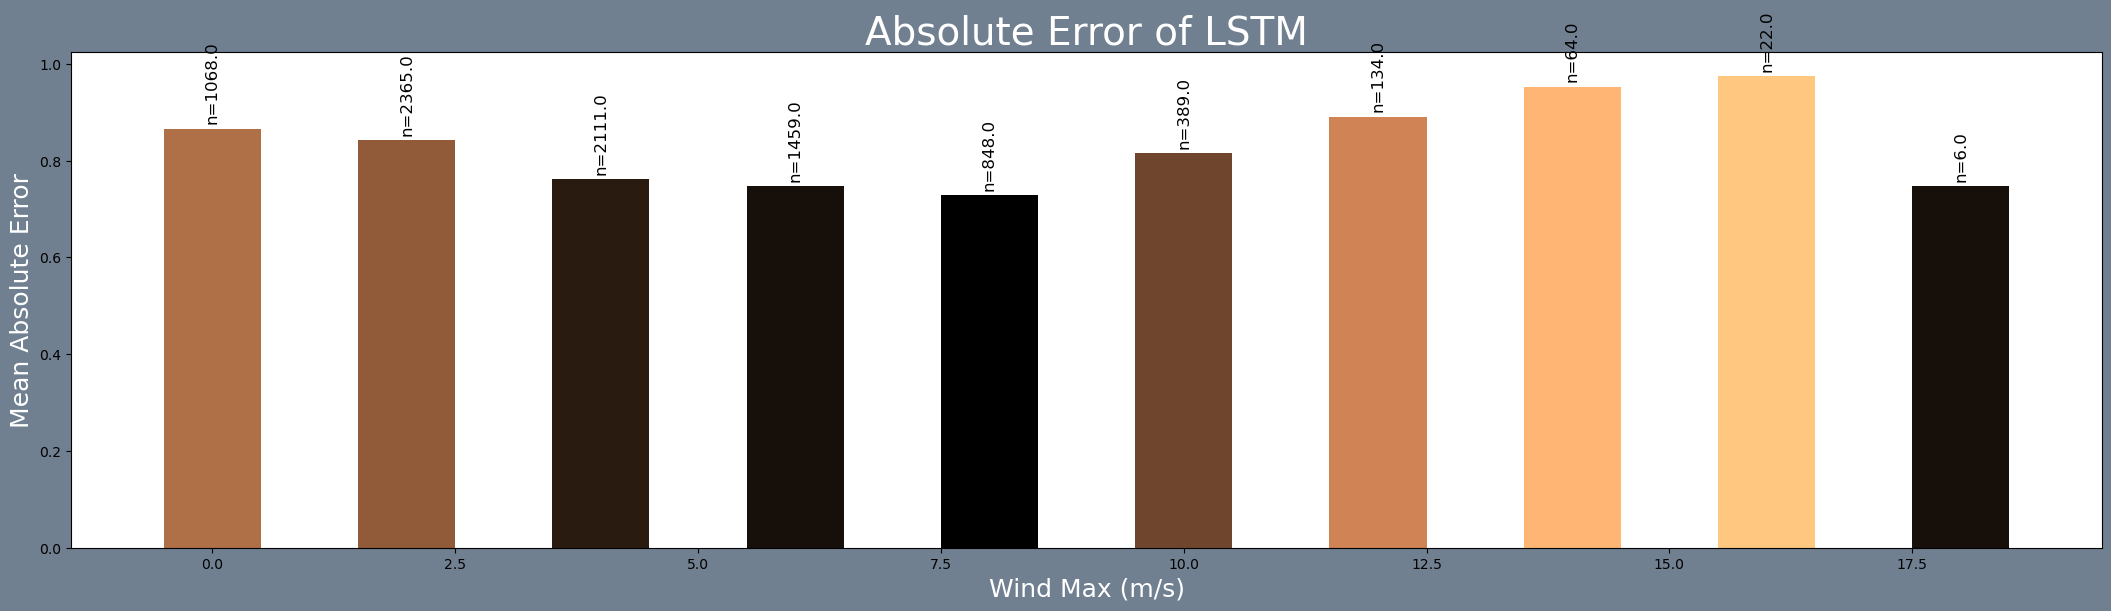

In [342]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)
print("Hello camera man")

In [343]:
wdir, instances = err_bucket(full_df, f"wdir_sonic_{station}", 45)

/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bVI9uYYP3h/ipykernel_851986/1558746766.py:20: FutureWarning: Ch

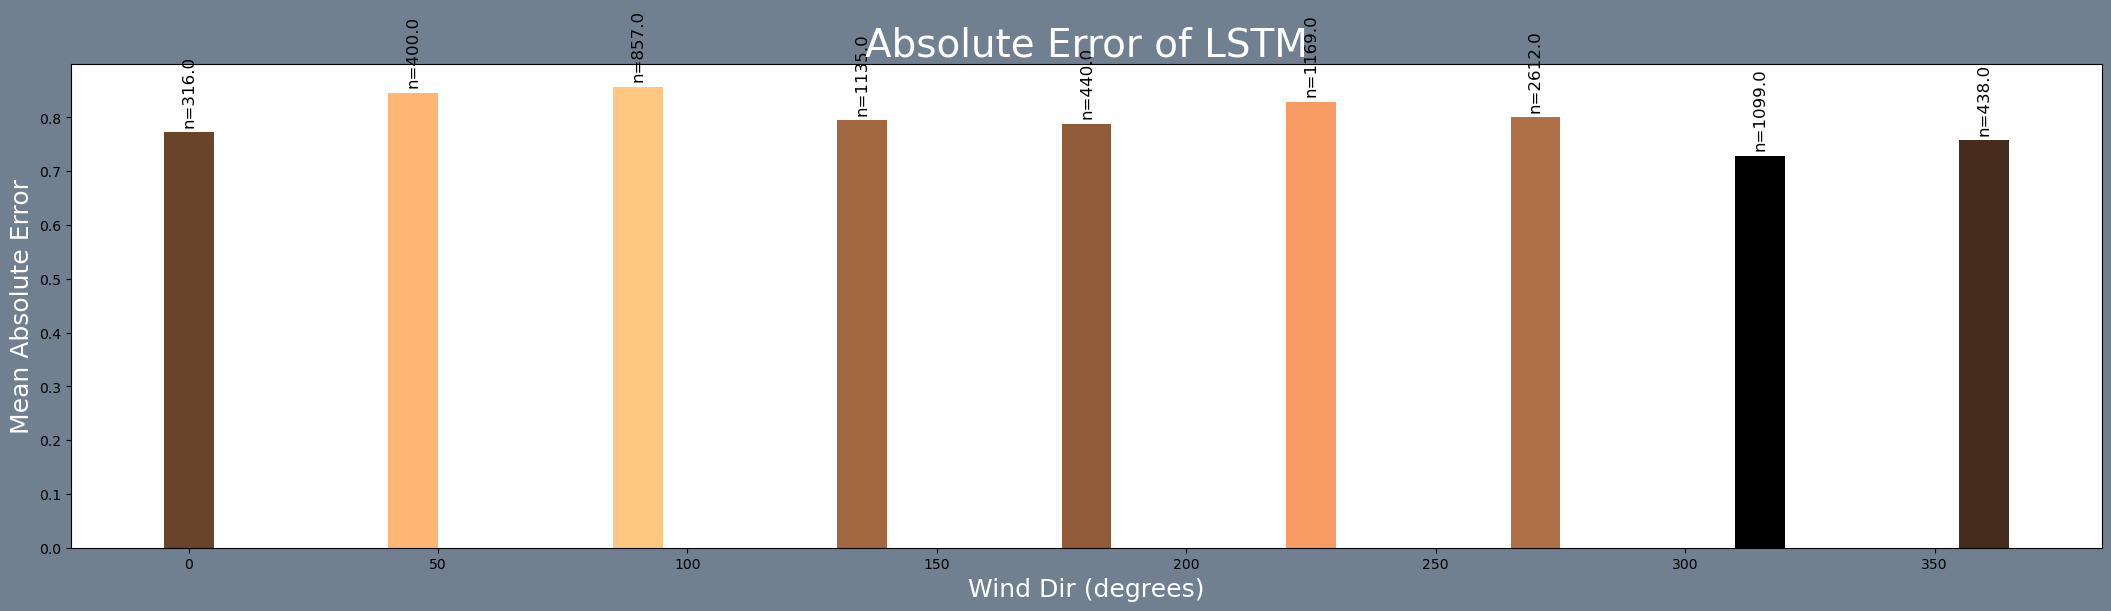

In [344]:
plot_buckets(wdir, instances, "Wind Dir (degrees)", "copper", 10.0)